In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 percent More buy CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

## Train Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


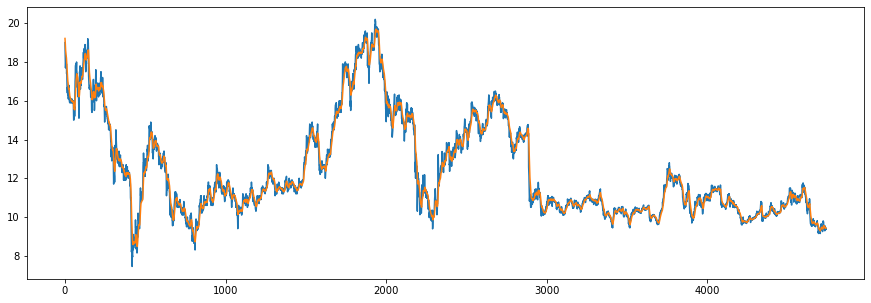

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


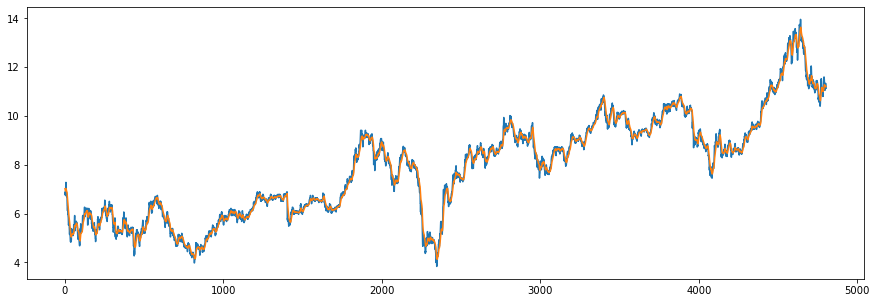

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


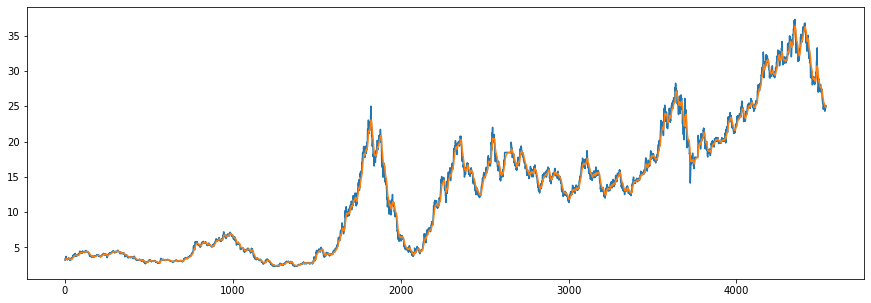

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


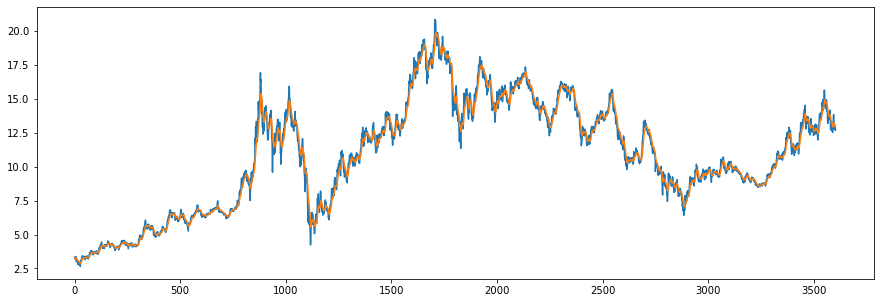

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


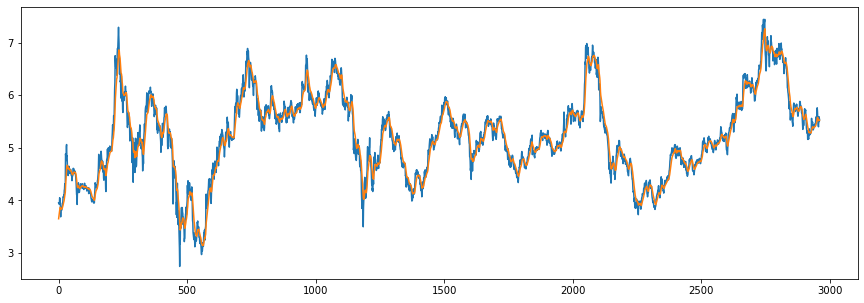

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


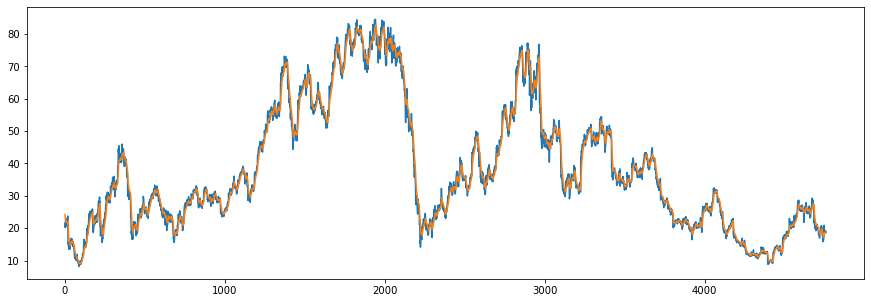

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


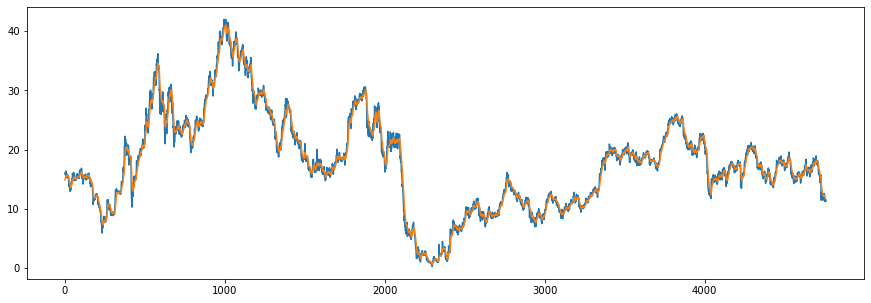

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


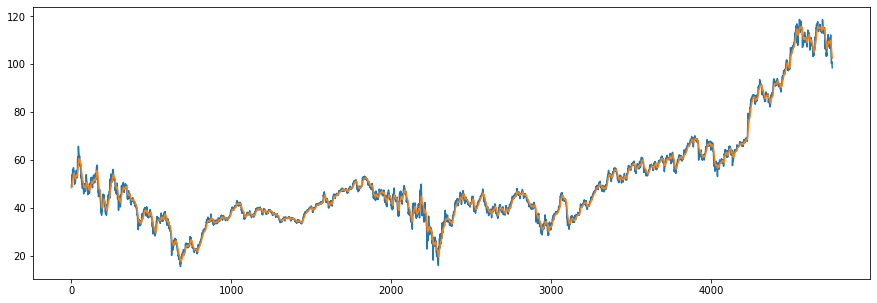

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


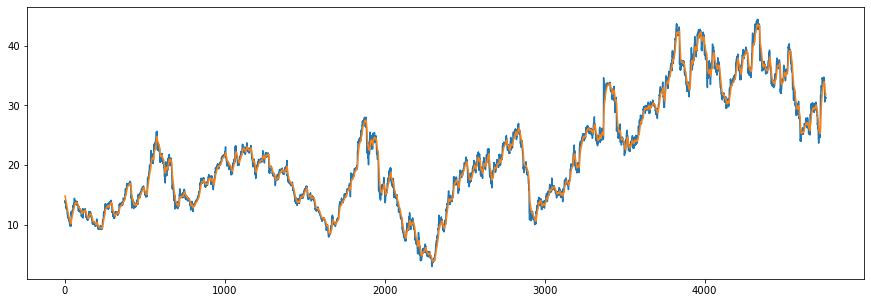

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


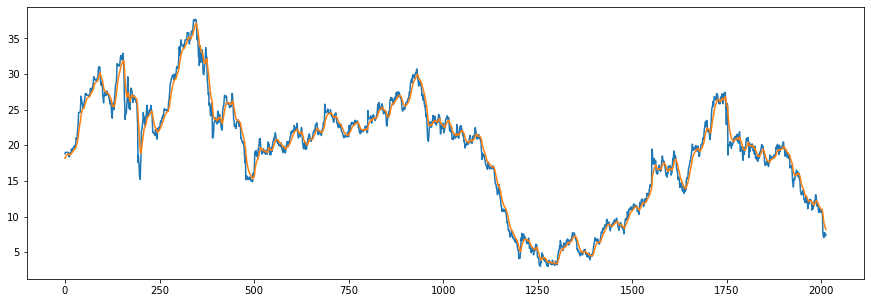

In [10]:
sequential_data = []
labels = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1
            
    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
        
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(41550, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [13]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1384]
class_1 = class_1[0:1845]
class_2 = class_2[0:1384]

class_0_labels = class_0_labels[0:1384]
class_1_labels = class_1_labels[0:1845]
class_2_labels = class_2_labels[0:1384]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(4613, 64, 64, 1)


Counter({0.0: 1384, 1.0: 1845, 2.0: 1384})

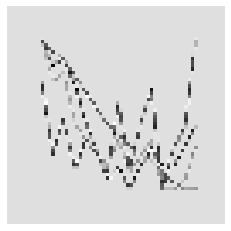

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 ... 0 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 1.1111111111111112, 1: 0.8333333333333334, 2: 1.1111111111111112}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.4342 - accuracy: 0.3438 - mse: 5.9836 - weighted_accuracy: 0.3690 - weighted_mse: 5.9997WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 29ms/step - loss: 0.2331 - accuracy: 0.3485 - mse: 1.5788 - weighted_accuracy: 0.3428 - weighted_mse: 1.5772 - val_loss: 0.1982 - val_accuracy: 0.3835 - val_mse: 0.9199 - val_weighted_accuracy: 0.3835 - val_weighted_mse: 0.9199
Epoch 2/20
29/29 [==============================] - 0s 13ms/step - loss: 0.2027 - accuracy: 0.3583 - mse: 1.1695 - weighted_accuracy: 0.3473 - weighted_mse: 1.1732 - val_loss: 0.1973

Price increase from previously bought: 936.7487050107794%
Share price: $0.1039599763949559
Shares owned at the moment: 0
Cash capital at the moment: $238.86552795268875


Share price: $0.3724161374520112
Shares owned at the moment: 639
Cash capital at the moment: $0.23718786331605202


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $181.95825321471915


Share price: $0.3589936494241448
Shares owned at the moment: 505
Cash capital at the moment: $0.1679078248882604


Price increase from previously bought: -5.867512890592607%
Share price: $0.3388589573073857
Shares owned at the moment: 0
Cash capital at the moment: $170.82109088815739


Share price: $0.3120133412016799
Shares owned at the moment: 545
Cash capital at the moment: $0.3061899381158071


Price increase from previously bought: -23.87029502991531%
Share price: $0.238188056923484
Shares owned at the moment: 0
Cash capital at th



O39.SI


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2088 - accuracy: 0.0826 - mse: 1.2840 - weighted_accuracy: 0.0826 - weighted_mse: 1.2840
Test loss: 0.2087690681219101
Test accuracy: 0.08256880939006805


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 105
actual holds but predicted sell: 93
actual predicted holds: 3
Percentage buys correct: 6.956521739130435%
Percentage sells correct: 7.0%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 53.535353535353536%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price increas

7/7 [==============================] - 0s 21ms/step - loss: 0.2131 - accuracy: 0.0616 - mse: 1.3052 - weighted_accuracy: 0.0616 - weighted_mse: 1.3052
Test loss: 0.21305863559246063
Test accuracy: 0.061611372977495193


number of predictions: 211
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 116
actual holds but predicted sell: 75
actual predicted holds: 3
Percentage buys correct: 4.0%
Percentage sells correct: 6.097560975609756%
Percentage holds correct: 75.0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 47.2%
Percentage high sells correct: 53.08641975308642%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price increase from previously bought: 11.91804570906054


Share price: $0.4207744164504643
Shares owned at the moment: 80
Cash capital at the moment: $0.020340097096166687


Price increase from previously bought: 11.296716902307203%
Share price: $0.4695959583796625
Shares owned at the moment: 0
Cash capital at the moment: $37.48470565662564


Share price: $0.38205379461628364
Shares owned at the moment: 97
Cash capital at the moment: $0.3235747291322326


Price increase from previously bought: 15.984908470475734%
Share price: $0.44434333703965856
Shares owned at the moment: 0
Cash capital at the moment: $43.306349836823784


Share price: $0.39720533531004043
Shares owned at the moment: 108
Cash capital at the moment: $0.290203638752331


Price increase from previously bought: 20.43678352011018%
Share price: $0.4796968784746798
Shares owned at the moment: 0
Cash capital at the moment: $51.954996541110766


Share price: $0.39215487526253145
Shares owned at the moment: 132
Cash capital at the moment: $0.04820078673631656


Price increase from p

7/7 [==============================] - 0s 14ms/step - loss: 0.2059 - accuracy: 0.1187 - mse: 1.2465 - weighted_accuracy: 0.1187 - weighted_mse: 1.2465
Test loss: 0.2058553695678711
Test accuracy: 0.11872146278619766


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 102
actual holds but predicted sell: 88
actual predicted holds: 7
Percentage buys correct: 7.964601769911504%
Percentage sells correct: 10.204081632653061%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.214285714285715%
Percentage high sells correct: 53.06122448979592%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase from previous

7/7 [==============================] - 0s 15ms/step - loss: 0.2070 - accuracy: 0.1324 - mse: 1.2504 - weighted_accuracy: 0.1324 - weighted_mse: 1.2504
Test loss: 0.20699338614940643
Test accuracy: 0.13242009282112122


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 92
actual holds but predicted sell: 95
actual predicted holds: 10
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 100.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 51.45631067961165%
Percentage high sells correct: 56.19047619047619%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price increase from previo

Epoch 4/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1776 - accuracy: 0.5531 - mse: 1.3252 - weighted_accuracy: 0.5343 - weighted_mse: 1.3228 - val_loss: 0.1688 - val_accuracy: 0.5894 - val_mse: 1.0497 - val_weighted_accuracy: 0.5894 - val_weighted_mse: 1.0497
Epoch 5/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1755 - accuracy: 0.5501 - mse: 1.3227 - weighted_accuracy: 0.5336 - weighted_mse: 1.3199 - val_loss: 0.1707 - val_accuracy: 0.5775 - val_mse: 1.0287 - val_weighted_accuracy: 0.5775 - val_weighted_mse: 1.0287
Epoch 6/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1752 - accuracy: 0.5526 - mse: 1.3487 - weighted_accuracy: 0.5376 - weighted_mse: 1.3486 - val_loss: 0.1671 - val_accuracy: 0.5785 - val_mse: 1.2010 - val_weighted_accuracy: 0.5785 - val_weighted_mse: 1.2010
Epoch 7/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1752 - accuracy: 0.5691 - mse: 1.3420 - weighted_accuracy: 0.5521 - weighted

Cash capital at the moment: $0.21984434871965775


Price increase from previously bought: -0.27424582398405395%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $16.42970463828144


Share price: $0.3589936494241448
Shares owned at the moment: 45
Cash capital at the moment: $0.23056495007868705


Price increase from previously bought: -5.867512890592607%
Share price: $0.3388589573073857
Shares owned at the moment: 0
Cash capital at the moment: $15.437284232944254


Share price: $0.3120133412016799
Shares owned at the moment: 49
Cash capital at the moment: $0.10658671633501093


Price increase from previously bought: -23.87029502991531%
Share price: $0.238188056923484
Shares owned at the moment: 0
Cash capital at the moment: $11.745705664915286


Share price: $0.2985908531738153
Shares owned at the moment: 39
Cash capital at the moment: $0.06863852213359856


Price increase from previously bought: 24.382511319263543%
Share price: $0.37241613745201

7/7 [==============================] - 0s 4ms/step - loss: 0.2221 - accuracy: 0.1147 - mse: 1.4741 - weighted_accuracy: 0.1147 - weighted_mse: 1.4741
Test loss: 0.22207632660865784
Test accuracy: 0.11467889696359634


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 109
actual holds but predicted sell: 83
actual predicted holds: 9
Percentage buys correct: 6.837606837606837%
Percentage sells correct: 8.791208791208792%
Percentage holds correct: 90.0%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price increase from previously b

Shares owned at the moment: 0
Cash capital at the moment: $60.36490029420262


Share price: $0.2935365148933824
Shares owned at the moment: 205
Cash capital at the moment: $0.024433530788080304


Price increase from previously bought: -3.381585377912033%
Share price: $0.2843902554262392
Shares owned at the moment: 0
Cash capital at the moment: $58.16411088667057


Share price: $0.2721951458852663
Shares owned at the moment: 213
Cash capital at the moment: $0.027106506406553876


Price increase from previously bought: 28.76777363470473%
Share price: $0.3514635032787641
Shares owned at the moment: 0
Cash capital at the moment: $74.68296295773776


Share price: $0.6654877920245792
Shares owned at the moment: 111
Cash capital at the moment: $0.6106778944939606


Price increase from previously bought: 14.345604587189253%
Share price: $0.7630486683523638
Shares owned at the moment: 0
Cash capital at the moment: $85.0761594755918


Share price: $0.717317080262301
Shares owned at the moment: 1

7/7 [==============================] - 0s 4ms/step - loss: 0.2219 - accuracy: 0.1080 - mse: 1.4885 - weighted_accuracy: 0.1080 - weighted_mse: 1.4885
Test loss: 0.2219422459602356
Test accuracy: 0.10798121988773346


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 122
actual holds but predicted sell: 63
actual predicted holds: 8
Percentage buys correct: 6.015037593984962%
Percentage sells correct: 9.722222222222221%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.61654135338346%
Percentage high sells correct: 59.15492957746479%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase from previousl

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.2132 - accuracy: 0.1598 - mse: 1.4042 - weighted_accuracy: 0.1598 - weighted_mse: 1.4042
Test loss: 0.21322011947631836
Test accuracy: 0.15981735289096832


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 117
actual holds but predicted sell: 65
actual predicted holds: 15
Percentage buys correct: 7.751937984496124%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.21875%
Percentage high sells correct: 58.666666666666664%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at the moment: $0.9

3         -31.900348  


AXL


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2197 - accuracy: 0.1147 - mse: 1.4178 - weighted_accuracy: 0.1147 - weighted_mse: 1.4178
Test loss: 0.21967828273773193
Test accuracy: 0.11467889696359634


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 114
actual holds but predicted sell: 77
actual predicted holds: 11
Percentage buys correct: 5.737704918032787%
Percentage sells correct: 8.235294117647058%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 44.62809917355372%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 72.72727272727273%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at 


Share price: $0.18894735124963175
Shares owned at the moment: 276
Cash capital at the moment: $0.15714169102040643


Price increase from previously bought: 105.28505457158279%
Share price: $0.38894734497545874
Shares owned at the moment: 0
Cash capital at the moment: $107.21139786941066


Share price: $0.6415789292063412
Shares owned at the moment: 166
Cash capital at the moment: $0.41641483997531736


Price increase from previously bought: 17.519313557360583%
Share price: $0.7560525962041695
Shares owned at the moment: 0
Cash capital at the moment: $125.57600779970025


Share price: $0.7428947770050682
Shares owned at the moment: 168
Cash capital at the moment: $0.42646787587243296


Price increase from previously bought: -21.999842379289102%
Share price: $0.581052609536787
Shares owned at the moment: 0
Cash capital at the moment: $97.77485997244663


Share price: $0.6678946930880041
Shares owned at the moment: 145
Cash capital at the moment: $0.6638064658172027


Price increase from

29/29 [==============================] - 0s 12ms/step - loss: 0.1599 - accuracy: 0.6168 - mse: 1.4561 - weighted_accuracy: 0.6058 - weighted_mse: 1.4540 - val_loss: 0.1584 - val_accuracy: 0.6089 - val_mse: 1.3010 - val_weighted_accuracy: 0.6089 - val_weighted_mse: 1.3010
Epoch 9/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1585 - accuracy: 0.6423 - mse: 1.4914 - weighted_accuracy: 0.6273 - weighted_mse: 1.4868 - val_loss: 0.1592 - val_accuracy: 0.6121 - val_mse: 1.2064 - val_weighted_accuracy: 0.6121 - val_weighted_mse: 1.2064
Epoch 10/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1575 - accuracy: 0.6363 - mse: 1.4860 - weighted_accuracy: 0.6221 - weighted_mse: 1.4802 - val_loss: 0.1597 - val_accuracy: 0.6013 - val_mse: 1.2270 - val_weighted_accuracy: 0.6013 - val_weighted_mse: 1.2270
Epoch 11/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1569 - accuracy: 0.6379 - mse: 1.4660 - weighted_accuracy: 0.6231 - weighted_mse: 1.4

Shares owned at the moment: 55
Cash capital at the moment: $0.05641441748013776


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $15.697507679337996


Share price: $0.3589936494241448
Shares owned at the moment: 43
Cash capital at the moment: $0.21832975505536467


Price increase from previously bought: -5.867512890592607%
Share price: $0.3388589573073857
Shares owned at the moment: 0
Cash capital at the moment: $14.74919484757135


Share price: $0.3120133412016799
Shares owned at the moment: 47
Cash capital at the moment: $0.04424008674207691


Price increase from previously bought: -15.289894902951174%
Share price: $0.2650336730291907
Shares owned at the moment: 0
Cash capital at the moment: $12.466567116875016


Share price: $0.2247655688956185
Shares owned at the moment: 55
Cash capital at the moment: $0.07046503532053627


Price increase from previously bought: 11.636828125712428

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2246 - accuracy: 0.1881 - mse: 1.5627 - weighted_accuracy: 0.1881 - weighted_mse: 1.5627
Test loss: 0.22459785640239716
Test accuracy: 0.18807339668273926


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 96
actual holds but predicted sell: 79
actual predicted holds: 26
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 92.85714285714286%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 54.11764705882353%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Ca

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2321 - accuracy: 0.1564 - mse: 1.5991 - weighted_accuracy: 0.1564 - weighted_mse: 1.5991
Test loss: 0.23205797374248505
Test accuracy: 0.15639810264110565


number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 107
actual holds but predicted sell: 62
actual predicted holds: 25
Percentage buys correct: 2.6785714285714284%
Percentage sells correct: 7.246376811594203%
Percentage holds correct: 83.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 50.892857142857146%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 14


Share price: $0.3450168735329129
Shares owned at the moment: 76
Cash capital at the moment: $0.24297035381960796


Price increase from previously bought: 10.91774940785819%
Share price: $0.3837373348158635
Shares owned at the moment: 0
Cash capital at the moment: $29.326806696848713


Share price: $0.33828287328582496
Shares owned at the moment: 86
Cash capital at the moment: $0.15447569473566958


Price increase from previously bought: 35.955347343908684%
Share price: $0.46117841793299474
Shares owned at the moment: 0
Cash capital at the moment: $39.70675094113207


Share price: $0.4207744164504643
Shares owned at the moment: 94
Cash capital at the moment: $0.04518560813597361


Price increase from previously bought: 11.296716902307203%
Share price: $0.4695959583796625
Shares owned at the moment: 0
Cash capital at the moment: $44.065815140583105


Share price: $0.4190908762508847
Shares owned at the moment: 104
Cash capital at the moment: $0.36050401988333647


Price increase from pr

7/7 [==============================] - 0s 5ms/step - loss: 0.2142 - accuracy: 0.2420 - mse: 1.4780 - weighted_accuracy: 0.2420 - weighted_mse: 1.4780
Test loss: 0.2142230123281479
Test accuracy: 0.24200913310050964


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 99
actual holds but predicted sell: 64
actual predicted holds: 34
Percentage buys correct: 9.00900900900901%
Percentage sells correct: 12.32876712328767%
Percentage holds correct: 97.14285714285714%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.549549549549546%
Percentage high sells correct: 60.273972602739725%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at the moment: $0.9477687090784883


Price

Shares owned at the moment: 108
Cash capital at the moment: $0.4159929050822342


Price increase from previously bought: 1.2193529348202725%
Share price: $0.5585347737425168
Shares owned at the moment: 0
Cash capital at the moment: $60.571863641472525


Share price: $0.5860073184896668
Shares owned at the moment: 103
Cash capital at the moment: $0.047123264074649285


Price increase from previously bought: 5.336023815186386%
Share price: $0.6189743197865589
Shares owned at the moment: 0
Cash capital at the moment: $63.62615372601067


Share price: $0.4687912265456817
Shares owned at the moment: 135
Cash capital at the moment: $0.16529939948854633


Price increase from previously bought: -85.40504015504862%
Share price: $0.06860804597199253
Shares owned at the moment: 0
Cash capital at the moment: $9.401914868640436


Share price: $0.09608054705273604
Shares owned at the moment: 97
Cash capital at the moment: $0.05647231859872193


Price increase from previously bought: -54.452354992063




RUNNING EPOCHS 60 - 80



Epoch 1/20
29/29 [==============================] - 1s 19ms/step - loss: 0.1503 - accuracy: 0.6610 - mse: 1.5354 - weighted_accuracy: 0.6482 - weighted_mse: 1.5260 - val_loss: 0.1596 - val_accuracy: 0.6056 - val_mse: 1.2687 - val_weighted_accuracy: 0.6056 - val_weighted_mse: 1.2687
Epoch 2/20
29/29 [==============================] - 0s 14ms/step - loss: 0.1501 - accuracy: 0.6680 - mse: 1.5187 - weighted_accuracy: 0.6561 - weighted_mse: 1.5126 - val_loss: 0.1579 - val_accuracy: 0.6121 - val_mse: 1.3061 - val_weighted_accuracy: 0.6121 - val_weighted_mse: 1.3061
Epoch 3/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1496 - accuracy: 0.6759 - mse: 1.5359 - weighted_accuracy: 0.6652 - weighted_mse: 1.5279 - val_loss: 0.1572 - val_accuracy: 0.6078 - val_mse: 1.3759 - val_weighted_accuracy: 0.6078 - val_weighted_mse: 1.3759
Epoch 4/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1491 - accuracy: 0.6688 - mse: 1.5425 - weighte

Shares owned at the moment: 0
Cash capital at the moment: $38.646383706842514


Share price: $0.42610736966342366
Shares owned at the moment: 90
Cash capital at the moment: $0.1912588631426857


Price increase from previously bought: -8.127785815841404%
Share price: $0.3925508295687721
Shares owned at the moment: 0
Cash capital at the moment: $35.423677194013905


Share price: $0.4126848816355573
Shares owned at the moment: 85
Cash capital at the moment: $0.24899716390922322


Price increase from previously bought: 14.322156124474205%
Share price: $0.47308767788588857
Shares owned at the moment: 0
Cash capital at the moment: $40.35086553950393


Share price: $0.5200673460583796
Shares owned at the moment: 77
Cash capital at the moment: $0.19555563248083985


Price increase from previously bought: 2.29958956799452%
Share price: $0.5334898340862451
Shares owned at the moment: 0
Cash capital at the moment: $41.16130638475394


Share price: $0.5402013981251648
Shares owned at the moment: 7

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2546 - accuracy: 0.1789 - mse: 1.7655 - weighted_accuracy: 0.1789 - weighted_mse: 1.7655
Test loss: 0.2545766532421112
Test accuracy: 0.17889907956123352


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 94
actual holds but predicted sell: 84
actual predicted holds: 23
Percentage buys correct: 7.8431372549019605%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 95.83333333333333%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 53.92156862745098%
Percentage high sells correct: 56.043956043956044%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
C

Price increase from previously bought: -8.45518681086016%
Share price: $0.4093902009097994
Shares owned at the moment: 0
Cash capital at the moment: $62.58623989814875


Share price: $0.3849999818278531
Shares owned at the moment: 162
Cash capital at the moment: $0.04472535013223222


Price increase from previously bought: 10.781851411277055%
Share price: $0.4276830105984313
Shares owned at the moment: 0
Cash capital at the moment: $69.1388402858565


Share price: $0.4307315699179155
Shares owned at the moment: 160
Cash capital at the moment: $0.03226720822614482


Price increase from previously bought: -15.803409921953737%
Share price: $0.363658612819737
Shares owned at the moment: 0
Cash capital at the moment: $58.057635469743374


Share price: $0.2539023361966335
Shares owned at the moment: 228
Cash capital at the moment: $0.008706052115648788


Price increase from previously bought: 8.108162731450609%
Share price: $0.275243995959096
Shares owned at the moment: 0
Cash capital at the

7/7 [==============================] - 0s 5ms/step - loss: 0.2476 - accuracy: 0.1643 - mse: 1.7281 - weighted_accuracy: 0.1643 - weighted_mse: 1.7281
Test loss: 0.24755795300006866
Test accuracy: 0.16431924700737


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 106
actual holds but predicted sell: 68
actual predicted holds: 19
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 10.256410256410257%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.55172413793103%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase fr

Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previously bought: 65.28731567555946%
Share price: $0.0989171603096468
Shares owned at the moment: 0
Cash capital at the moment: $164.7952544026971


Share price: $0.1926751480928941
Shares owned at the moment: 852
Cash capital at the moment: $0.18459035556969638


Price increase from previously bought: -10.95558635747601%
Share price: $0.1720382636077813
Shares owned at the moment: 0
Cash capital at the moment: $146.35810529776631


Share price: $0.16872623102977413
Shares owned at the moment: 865
Cash capital at the moment: $0.008557934949607215


Price increase from previously bought: 2.436195315535006%
Share price: $0.1733120325780073
Shares owned at the moment: 0
Cash capital at the moment: $149.511200117431


Share price: $0.031146547576816667
Shares owned at the moment: 4787
Cash capital at the moment: $0.002655928271508401


Pric

Shares owned at the moment: 0
Cash capital at the moment: $365.26315278824046


Share price: $0.3605171738353048
Shares owned at the moment: 1010
Cash capital at the moment: $0.13947076425500882


Price increase from previously bought: -5.621795818540254%
Share price: $0.3411853209261988
Shares owned at the moment: 0
Cash capital at the moment: $343.7890026708432


Share price: $0.33762420374584257
Shares owned at the moment: 1015
Cash capital at the moment: $0.15804231010741887


Price increase from previously bought: -15.300954761356444%
Share price: $0.2867508793792364
Shares owned at the moment: 0
Cash capital at the moment: $290.40979148796504


Share price: $0.30235200113438254
Shares owned at the moment: 957
Cash capital at the moment: $0.26321152337555986


Price increase from previously bought: 8.78681605120275%
Share price: $0.3298236428682695
Shares owned at the moment: 0
Cash capital at the moment: $315.0364243761909


Share price: $0.3947719513602499
Shares owned at the mo

Shares owned at the moment: 32
Cash capital at the moment: $0.030743388578529762


Price increase from previously bought: 219.0640993736341%
Share price: $0.11989009165578655
Shares owned at the moment: 0
Cash capital at the moment: $3.8566759934979897


Share price: $0.19681318201468057
Shares owned at the moment: 19
Cash capital at the moment: $0.10694204645879157


Price increase from previously bought: -15.12268199115302%
Share price: $0.16750913719548155
Shares owned at the moment: 0
Cash capital at the moment: $3.280863300754477


Share price: $0.1189743197865588
Shares owned at the moment: 27
Cash capital at the moment: $0.05972282327323741


Price increase from previously bought: 51.154544545123%
Share price: $0.18032963769982846
Shares owned at the moment: 0
Cash capital at the moment: $4.915233565569393


Share price: $0.25084249963975225
Shares owned at the moment: 19
Cash capital at the moment: $0.1361195518079228


Price increase from previously bought: 14.288495834298033%

Share price: $0.6902631237582821
Shares owned at the moment: 159
Cash capital at the moment: $0.26085082192744835


Price increase from previously bought: 5.999008517931559%
Share price: $0.7336841655338908
Shares owned at the moment: 0
Cash capital at the moment: $116.5958297404364


Share price: $0.6836842141587314
Shares owned at the moment: 170
Cash capital at the moment: $0.049890963332856586




Capital at the end of test period: $108.37223305498011
profit gained: 8.372233054980114%


Capital at the end of test period if Buy and Hold: $67.49022981476901
profit gained: -32.50977018523099%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.200000      6.086957       7.575758      91.176471   
1       0.218605      6.542056      12.162162      91.176471   
2       0.164319      6.896552      10.256410     100.000000   
3       0.228310      9.433962      13.253012      96.666667   
4       0.210046      9.574468       8.602151      90.625000   

   correct_low



Percentage low buys correct: 55.88235294117647%
Percentage high sells correct: 43.13725490196079%
Percentage mid holds correct: 76.5625%


Capital: 100
Share price: $0.7012750947593986
Shares owned at the moment: 142
Cash capital at the moment: $0.14508861966184838


Price increase from previously bought: 35.038819779174624%
Share price: $0.9495978437996435
Shares owned at the moment: 0
Cash capital at the moment: $134.61716448120745


Share price: $0.8891950475493122
Shares owned at the moment: 150
Cash capital at the moment: $0.8711143916965227


Price increase from previously bought: -12.317494692001695%
Share price: $0.7818125831264899
Shares owned at the moment: 0
Cash capital at the moment: $117.82050417013033


Share price: $0.6073157584144167
Shares owned at the moment: 193
Cash capital at the moment: $0.2862299573694713


Price increase from previously bought: 18.460840295027726%
Share price: $0.7214097868761586
Shares owned at the moment: 0
Cash capital at the moment: $139.

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2744 - accuracy: 0.2110 - mse: 2.0142 - weighted_accuracy: 0.2110 - weighted_mse: 2.0142
Test loss: 0.27438685297966003
Test accuracy: 0.2110091745853424


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 99
actual holds but predicted sell: 69
actual predicted holds: 33
Percentage buys correct: 7.4766355140186915%
Percentage sells correct: 6.756756756756757%
Percentage holds correct: 89.1891891891892%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 55.14018691588785%
Percentage high sells correct: 53.42465753424658%
Percentage mid holds correct: 81.08108108108108%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cas

Cash capital at the moment: $0.19080858838402648


Price increase from previously bought: 6.232810002080691%
Share price: $0.3484146532049339
Shares owned at the moment: 0
Cash capital at the moment: $30.072068698525374


Share price: $0.2539023361966335
Shares owned at the moment: 118
Cash capital at the moment: $0.02920171922681547


Price increase from previously bought: 89.53644238281913%
Share price: $0.4825608581556373
Shares owned at the moment: 0
Cash capital at the moment: $56.814791983120514


Share price: $0.4459755295327186
Shares owned at the moment: 127
Cash capital at the moment: $0.0201427787759485


Price increase from previously bought: -4.3646838092525115%
Share price: $0.4276830105984313
Shares owned at the moment: 0
Cash capital at the moment: $54.18651683332522


Share price: $0.4307315699179155
Shares owned at the moment: 125
Cash capital at the moment: $0.1970066164264992


Price increase from previously bought: -15.803409921953737%
Share price: $0.3636586128197

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2631 - accuracy: 0.2347 - mse: 1.9688 - weighted_accuracy: 0.2347 - weighted_mse: 1.9688
Test loss: 0.2631116807460785
Test accuracy: 0.23474177718162537


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 107
actual holds but predicted sell: 50
actual predicted holds: 36
Percentage buys correct: 6.779661016949152%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 97.29729729729729%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.91525423728814%
Percentage high sells correct: 56.14035087719298%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital a

Shares owned at the moment: 0
Cash capital at the moment: $1333.6478331194496


Share price: $0.2573885597935692
Shares owned at the moment: 5167
Cash capital at the moment: $0.06384627283068767


Price increase from previously bought: 14.434111045417609%
Share price: $0.2953502961857881
Shares owned at the moment: 0
Cash capital at the moment: $1521.94212046872


Share price: $0.2803185394323149
Shares owned at the moment: 5414
Cash capital at the moment: $0.12402540782932192


Price increase from previously bought: 2.263639936376549%
Share price: $0.2874522676800322
Shares owned at the moment: 0
Cash capital at the moment: $1552.1108695401692


Share price: $0.31012741577292613
Shares owned at the moment: 4991
Cash capital at the moment: $0.008361104157529553


Price increase from previously bought: -6.828376473663756%
Share price: $0.28974536283366503
Shares owned at the moment: 0
Cash capital at the moment: $1442.150639465747


Share price: $0.23496824324652743
Shares owned at the 

Share price: $0.3947719513602499
Shares owned at the moment: 183
Cash capital at the moment: $0.1843386248406631


Price increase from previously bought: 8.678895284093336%
Share price: $0.43021363856775974
Shares owned at the moment: 0
Cash capital at the moment: $78.69692946913148


Share price: $0.3542428799650579
Shares owned at the moment: 221
Cash capital at the moment: $0.19396188655491642


Price increase from previously bought: 19.203353182357617%
Share price: $0.42343063215425536
Shares owned at the moment: 0
Cash capital at the moment: $93.5147916259536


Share price: $0.6162404487020587
Shares owned at the moment: 151
Cash capital at the moment: $0.20659002561920659


Price increase from previously bought: -4.143648094791019%
Share price: $0.592330053526082
Shares owned at the moment: 0
Cash capital at the moment: $89.40246305333088


Share price: $0.6294674923369679
Shares owned at the moment: 141
Cash capital at the moment: $0.40347061366475145


Price increase from previ

7/7 [==============================] - 0s 4ms/step - loss: 0.2472 - accuracy: 0.3151 - mse: 1.8846 - weighted_accuracy: 0.3151 - weighted_mse: 1.8846
Test loss: 0.2472034990787506
Test accuracy: 0.31506848335266113


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 86
actual holds but predicted sell: 59
actual predicted holds: 52
Percentage buys correct: 9.473684210526315%
Percentage sells correct: 11.940298507462687%
Percentage holds correct: 91.2280701754386%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.255319148936174%
Percentage high sells correct: 58.208955223880594%
Percentage mid holds correct: 82.45614035087719%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price 

Epoch 4/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1168 - accuracy: 0.7734 - mse: 1.8499 - weighted_accuracy: 0.7668 - weighted_mse: 1.8284 - val_loss: 0.1600 - val_accuracy: 0.5894 - val_mse: 1.7518 - val_weighted_accuracy: 0.5894 - val_weighted_mse: 1.7518
Epoch 5/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1143 - accuracy: 0.7783 - mse: 1.8663 - weighted_accuracy: 0.7724 - weighted_mse: 1.8444 - val_loss: 0.1608 - val_accuracy: 0.5980 - val_mse: 1.6967 - val_weighted_accuracy: 0.5980 - val_weighted_mse: 1.6967
Epoch 6/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1132 - accuracy: 0.7767 - mse: 1.8523 - weighted_accuracy: 0.7709 - weighted_mse: 1.8337 - val_loss: 0.1602 - val_accuracy: 0.6186 - val_mse: 1.7113 - val_weighted_accuracy: 0.6186 - val_weighted_mse: 1.7113
Epoch 7/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1142 - accuracy: 0.7780 - mse: 1.8616 - weighted_accuracy: 0.7732 - weighted

Price increase from previously bought: 2.29958956799452%
Share price: $0.5334898340862451
Shares owned at the moment: 0
Cash capital at the moment: $53.96510029265639


Share price: $0.5402013981251648
Shares owned at the moment: 99
Cash capital at the moment: $0.3380920476254943


Price increase from previously bought: 3.442788903091265%
Share price: $0.5603360902419257
Shares owned at the moment: 0
Cash capital at the moment: $55.65881348100777


Share price: $0.6542954265869076
Shares owned at the moment: 84
Cash capital at the moment: $0.5468554041659459


Price increase from previously bought: -4.365974428028796%
Share price: $0.6274498104812019
Shares owned at the moment: 0
Cash capital at the moment: $53.10769857836574


Share price: $0.6677185546647462
Shares owned at the moment: 79
Cash capital at the moment: $0.2128709038498826


Price increase from previously bought: 3.7352268703991554%
Share price: $0.694564170770452
Shares owned at the moment: 0
Cash capital at the moment:

7/7 [==============================] - 0s 5ms/step - loss: 0.3351 - accuracy: 0.1927 - mse: 2.4567 - weighted_accuracy: 0.1927 - weighted_mse: 2.4567
Test loss: 0.3351176679134369
Test accuracy: 0.19266055524349213


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 98
actual holds but predicted sell: 75
actual predicted holds: 28
Percentage buys correct: 7.547169811320755%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 90.3225806451613%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 55.660377358490564%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 87.09677419354838%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price increase from p

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.3402 - accuracy: 0.1801 - mse: 2.4878 - weighted_accuracy: 0.1801 - weighted_mse: 2.4878
Test loss: 0.340177446603775
Test accuracy: 0.18009479343891144


number of predictions: 211
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 110
actual holds but predicted sell: 56
actual predicted holds: 28
Percentage buys correct: 4.237288135593221%
Percentage sells correct: 8.064516129032258%
Percentage holds correct: 90.3225806451613%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 50.0%
Percentage high sells correct: 54.09836065573771%
Percentage mid holds correct: 80.64516129032258%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at 


Share price: $0.33828287328582496
Shares owned at the moment: 84
Cash capital at the moment: $0.15522347494790978


Price increase from previously bought: 47.86644257742256%
Share price: $0.5015824194155247
Shares owned at the moment: 0
Cash capital at the moment: $42.172281166967


Share price: $0.4207744164504643
Shares owned at the moment: 99
Cash capital at the moment: $0.4010581034923959


Price increase from previously bought: 11.296716902307203%
Share price: $0.4695959583796625
Shares owned at the moment: 0
Cash capital at the moment: $46.76321048341012


Share price: $0.4190908762508847
Shares owned at the moment: 111
Cash capital at the moment: $0.11619572958633739


Price increase from previously bought: 3.7317854065720413%
Share price: $0.43592595714422067
Shares owned at the moment: 0
Cash capital at the moment: $48.37091057417656


Share price: $0.44434333703965856
Shares owned at the moment: 108
Cash capital at the moment: $0.24986020279266086


Price increase from previ

Shares owned at the moment: 805
Cash capital at the moment: $0.06582828232728843


Price increase from previously bought: 14.467775854025877%
Share price: $0.7715289892751118
Shares owned at the moment: 0
Cash capital at the moment: $619.4386923487846


Share price: $0.7628662717522834
Shares owned at the moment: 809
Cash capital at the moment: $0.5826917631064816


Price increase from previously bought: 6.853184625693554%
Share price: $0.8173885597935697
Shares owned at the moment: 0
Cash capital at the moment: $660.0315514377037


Share price: $0.799808876340611
Shares owned at the moment: 822
Cash capital at the moment: $0.7806871207534414


Price increase from previously bought: 4.681507713493005%
Share price: $0.8395544335537928
Shares owned at the moment: 0
Cash capital at the moment: $688.9966187049228


Share price: $0.8441402351020251
Shares owned at the moment: 813
Cash capital at the moment: $0.8233210363470107


Price increase from previously bought: 0.8996162708799105%
Sha

7/7 [==============================] - 0s 5ms/step - loss: 0.3216 - accuracy: 0.1972 - mse: 2.3543 - weighted_accuracy: 0.1972 - weighted_mse: 2.3543
Test loss: 0.32160165905952454
Test accuracy: 0.197247713804245


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 104
actual holds but predicted sell: 66
actual predicted holds: 32
Percentage buys correct: 5.454545454545454%
Percentage sells correct: 6.944444444444445%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.87155963302752%
Percentage high sells correct: 56.94444444444444%
Percentage mid holds correct: 80.55555555555556%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price i

Shares owned at the moment: 0
Cash capital at the moment: $33.696754564700214


Share price: $0.08499998980446886
Shares owned at the moment: 395
Cash capital at the moment: $0.02942735300990762


Price increase from previously bought: 78.45661922545268%
Share price: $0.15210525044443896
Shares owned at the moment: 0
Cash capital at the moment: $59.94577695026802


Share price: $0.13631579211544126
Shares owned at the moment: 438
Cash capital at the moment: $0.07526763210169918


Price increase from previously bought: -9.90029727428352%
Share price: $0.12315787880374483
Shares owned at the moment: 0
Cash capital at the moment: $53.870074883122825


Share price: $0.18894735124963175
Shares owned at the moment: 284
Cash capital at the moment: $0.06145924690144966


Price increase from previously bought: 10.837282138352933%
Share price: $0.2100000250966922
Shares owned at the moment: 0
Cash capital at the moment: $59.53745635476152


Share price: $0.5231578662553991
Shares owned at the mo

Epoch 5/20
29/29 [==============================] - 0s 12ms/step - loss: 0.0993 - accuracy: 0.8046 - mse: 2.0790 - weighted_accuracy: 0.8011 - weighted_mse: 2.0580 - val_loss: 0.1700 - val_accuracy: 0.5883 - val_mse: 1.9983 - val_weighted_accuracy: 0.5883 - val_weighted_mse: 1.9983
Epoch 6/20
29/29 [==============================] - 0s 12ms/step - loss: 0.0969 - accuracy: 0.8182 - mse: 2.1710 - weighted_accuracy: 0.8144 - weighted_mse: 2.1438 - val_loss: 0.1683 - val_accuracy: 0.5872 - val_mse: 1.9601 - val_weighted_accuracy: 0.5872 - val_weighted_mse: 1.9601
Epoch 7/20
29/29 [==============================] - 0s 12ms/step - loss: 0.0970 - accuracy: 0.8182 - mse: 2.1278 - weighted_accuracy: 0.8148 - weighted_mse: 2.1011 - val_loss: 0.1754 - val_accuracy: 0.6067 - val_mse: 2.1204 - val_weighted_accuracy: 0.6067 - val_weighted_mse: 2.1204
Epoch 8/20
29/29 [==============================] - 0s 12ms/step - loss: 0.0976 - accuracy: 0.8106 - mse: 2.2231 - weighted_accuracy: 0.8076 - weighted

7/7 [==============================] - 0s 14ms/step - loss: 0.3373 - accuracy: 0.2465 - mse: 2.5353 - weighted_accuracy: 0.2465 - weighted_mse: 2.5353
Test loss: 0.33729231357574463
Test accuracy: 0.24651162326335907


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 107
actual holds but predicted sell: 50
actual predicted holds: 41
Percentage buys correct: 5.217391304347826%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 95.34883720930233%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 43.47826086956522%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 86.04651162790698%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase fr


Share price: $0.5498773329183202
Shares owned at the moment: 201
Cash capital at the moment: $0.07829173890313257


Price increase from previously bought: -20.30176325194436%
Share price: $0.4394477055943231
Shares owned at the moment: 0
Cash capital at the moment: $88.16437584409482


Share price: $0.30447822609568687
Shares owned at the moment: 288
Cash capital at the moment: $0.2334999734692218


Price increase from previously bought: 72.0637864187613%
Share price: $0.5253374807436784
Shares owned at the moment: 0
Cash capital at the moment: $151.11462714289956


Share price: $0.7216562981408023
Shares owned at the moment: 208
Cash capital at the moment: $0.5973297270761293


Price increase from previously bought: 3.9647300936764607%
Share price: $0.752331259628159
Shares owned at the moment: 0
Cash capital at the moment: $156.65189824922592


Share price: $0.8075460732901576
Shares owned at the moment: 193
Cash capital at the moment: $0.3669010258267349


Price increase from previ

Cash capital at the moment: $0.6148762172871187


Price increase from previously bought: 0.1607160017802478%
Share price: $0.7020731206474988
Shares owned at the moment: 0
Cash capital at the moment: $94.43396043909335


Share price: $0.6624389419507495
Shares owned at the moment: 142
Cash capital at the moment: $0.10894827525515893


Price increase from previously bought: 7.069323034762687%
Share price: $0.7112193801146416
Shares owned at the moment: 0
Cash capital at the moment: $100.82436908359949




Capital at the end of test period: $100.82436908359949
profit gained: 0.8243690835994926%


Capital at the end of test period if Buy and Hold: $75.43708035614208
profit gained: -24.562919643857924%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.246512      5.217391      10.526316      95.348837   
1       0.269767      5.769231      12.068966      84.905660   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         43.478261   



Price increase from previously bought: 3.7317854065720413%
Share price: $0.43592595714422067
Shares owned at the moment: 0
Cash capital at the moment: $50.64015164094916


Share price: $0.44434333703965856
Shares owned at the moment: 113
Cash capital at the moment: $0.29127486348266984


Price increase from previously bought: 7.660291027382882%
Share price: $0.4796968784746798
Shares owned at the moment: 0
Cash capital at the moment: $54.347956326135474


Share price: $0.41404041620337595
Shares owned at the moment: 130
Cash capital at the moment: $0.37468277090388824


Price increase from previously bought: -6.3565909514130325%
Share price: $0.3887877948633718
Shares owned at the moment: 0
Cash capital at the moment: $50.77810446647857


Share price: $0.3786868747683543
Shares owned at the moment: 133
Cash capital at the moment: $0.2742453978409216


Price increase from previously bought: 1.9424815708183774%
Share price: $0.3871044152150227
Shares owned at the moment: 0
Cash capital

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.3644 - accuracy: 0.2237 - mse: 2.6551 - weighted_accuracy: 0.2237 - weighted_mse: 2.6551
Test loss: 0.36441051959991455
Test accuracy: 0.22374428808689117


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 97
actual holds but predicted sell: 68
actual predicted holds: 32
Percentage buys correct: 8.411214953271028%
Percentage sells correct: 10.38961038961039%
Percentage holds correct: 91.42857142857143%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.66355140186916%
Percentage high sells correct: 53.246753246753244%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at 

7/7 [==============================] - 0s 5ms/step - loss: 0.3770 - accuracy: 0.1927 - mse: 2.6962 - weighted_accuracy: 0.1927 - weighted_mse: 2.6962
Test loss: 0.3770488202571869
Test accuracy: 0.19266055524349213


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 104
actual holds but predicted sell: 67
actual predicted holds: 31
Percentage buys correct: 5.454545454545454%
Percentage sells correct: 6.8493150684931505%
Percentage holds correct: 88.57142857142857%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 57.534246575342465%
Percentage mid holds correct: 79.41176470588235%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Pric

7/7 [==============================] - 0s 5ms/step - loss: 0.3459 - accuracy: 0.2603 - mse: 2.5974 - weighted_accuracy: 0.2603 - weighted_mse: 2.5974
Test loss: 0.34587591886520386
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 84
actual holds but predicted sell: 72
actual predicted holds: 41
Percentage buys correct: 8.602150537634408%
Percentage sells correct: 9.876543209876543%
Percentage holds correct: 91.11111111111111%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.26086956521739%
Percentage high sells correct: 54.32098765432099%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price

29/29 [==============================] - 1s 19ms/step - loss: 0.0870 - accuracy: 0.8423 - mse: 2.4027 - weighted_accuracy: 0.8415 - weighted_mse: 2.3694 - val_loss: 0.1821 - val_accuracy: 0.5645 - val_mse: 2.1162 - val_weighted_accuracy: 0.5645 - val_weighted_mse: 2.1162
Epoch 2/20
29/29 [==============================] - 0s 13ms/step - loss: 0.0850 - accuracy: 0.8412 - mse: 2.4928 - weighted_accuracy: 0.8384 - weighted_mse: 2.4590 - val_loss: 0.1809 - val_accuracy: 0.5818 - val_mse: 2.2510 - val_weighted_accuracy: 0.5818 - val_weighted_mse: 2.2510
Epoch 3/20
29/29 [==============================] - 0s 12ms/step - loss: 0.0852 - accuracy: 0.8474 - mse: 2.4661 - weighted_accuracy: 0.8451 - weighted_mse: 2.4340 - val_loss: 0.1899 - val_accuracy: 0.6056 - val_mse: 2.4080 - val_weighted_accuracy: 0.6056 - val_weighted_mse: 2.4080
Epoch 4/20
29/29 [==============================] - 0s 12ms/step - loss: 0.0835 - accuracy: 0.8434 - mse: 2.5837 - weighted_accuracy: 0.8410 - weighted_mse: 2.546

7/7 [==============================] - 0s 16ms/step - loss: 0.4116 - accuracy: 0.2140 - mse: 2.9556 - weighted_accuracy: 0.2140 - weighted_mse: 2.9556
Test loss: 0.41162002086639404
Test accuracy: 0.21395349502563477


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 98
actual holds but predicted sell: 66
actual predicted holds: 34
Percentage buys correct: 5.607476635514018%
Percentage sells correct: 8.219178082191782%
Percentage holds correct: 97.14285714285714%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 40.18691588785047%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 88.57142857142857%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price

Cash capital at the moment: $0.08010228716235623


Price increase from previously bought: -0.27424582398405395%
Share price: $0.21000003565137693
Shares owned at the moment: 0
Cash capital at the moment: $10.551229064829139


Share price: $0.2137383499098866
Shares owned at the moment: 49
Cash capital at the moment: $0.049248676594336516


Price increase from previously bought: -4.634810816347857%
Share price: $0.2043925196993911
Shares owned at the moment: 0
Cash capital at the moment: $10.036940249835007


Share price: $0.2137383499098866
Shares owned at the moment: 46
Cash capital at the moment: $0.17793825271662378




Capital at the end of test period: $10.240096741697625
profit gained: -89.75990325830237%


Capital at the end of test period if Buy and Hold: $21.761644528562254
profit gained: -78.23835547143774%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.213953      5.607477       8.219178      97.142857   

   correct_low_buys  correct_high_sells  c

number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 91
actual holds but predicted sell: 59
actual predicted holds: 43
Percentage buys correct: 6.122448979591836%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 87.75510204081633%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.12244897959184%
Percentage high sells correct: 68.65671641791045%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from previously bought: -0.5817825848549063%
Share price: $0.9856097809180537
Shares owned at the moment: 0
Cash capital at the moment: $99.15219117934178


Share price: $0.9581707117622773
Shares owned at th

7/7 [==============================] - 0s 16ms/step - loss: 0.4778 - accuracy: 0.1831 - mse: 3.2759 - weighted_accuracy: 0.1831 - weighted_mse: 3.2759
Test loss: 0.4778248369693756
Test accuracy: 0.18309858441352844


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 95
actual holds but predicted sell: 74
actual predicted holds: 24
Percentage buys correct: 7.619047619047619%
Percentage sells correct: 8.433734939759036%
Percentage holds correct: 96.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.76190476190476%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously bought: 1.46

7/7 [==============================] - 0s 5ms/step - loss: 0.5633 - accuracy: 0.1193 - mse: 3.6260 - weighted_accuracy: 0.1193 - weighted_mse: 3.6260
Test loss: 0.5633010268211365
Test accuracy: 0.11926605552434921


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 71
actual holds but predicted sell: 118
actual predicted holds: 12
Percentage buys correct: 12.048192771084338%
Percentage sells correct: 3.252032520325203%
Percentage holds correct: 100.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 50.602409638554214%
Percentage high sells correct: 47.540983606557376%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from pre

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.4732 - accuracy: 0.2146 - mse: 3.2715 - weighted_accuracy: 0.2146 - weighted_mse: 3.2715
Test loss: 0.47324657440185547
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 88
actual holds but predicted sell: 79
actual predicted holds: 30
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.112359550561798%
Percentage holds correct: 88.23529411764706%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.958333333333336%
Percentage high sells correct: 52.80898876404494%
Percentage mid holds correct: 78.78787878787878%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital a

   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.213953      5.607477       8.219178      97.142857   
1       0.265116      6.122449      11.764706      87.755102   
2       0.183099      7.619048       8.433735      96.000000   
3       0.214612      8.333333      10.112360      88.235294   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         40.186916           58.333333          88.571429     -89.759903   
1         56.122449           68.656716          83.673469     -23.637708   
2         44.761905           50.000000          84.000000     -72.500016   
3         48.958333           52.808989          78.787879     244.111950   

   buy_n_hold profit  
0         -78.238355  
1         -24.562920  
2         -84.289887  
3         -31.900348  


AXL


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.4810 - accuracy: 0.2064 - mse: 3.2676 - weighted_accuracy: 0.2064 - weighted_mse: 3.2676

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.4496 - accuracy: 0.2329 - mse: 3.1795 - weighted_accuracy: 0.2329 - weighted_mse: 3.1795
Test loss: 0.44957906007766724
Test accuracy: 0.232876718044281


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 79
actual holds but predicted sell: 83
actual predicted holds: 35
Percentage buys correct: 9.195402298850574%
Percentage sells correct: 8.602150537634408%
Percentage holds correct: 89.74358974358974%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.48837209302326%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 79.48717948717949%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at t




RUNNING EPOCHS 160 - 180



Epoch 1/20
29/29 [==============================] - 1s 26ms/step - loss: 0.0710 - accuracy: 0.8683 - mse: 3.0916 - weighted_accuracy: 0.8668 - weighted_mse: 3.0363 - val_loss: 0.2074 - val_accuracy: 0.5612 - val_mse: 2.5294 - val_weighted_accuracy: 0.5612 - val_weighted_mse: 2.5294
Epoch 2/20
29/29 [==============================] - 0s 14ms/step - loss: 0.0705 - accuracy: 0.8767 - mse: 3.0249 - weighted_accuracy: 0.8758 - weighted_mse: 2.9684 - val_loss: 0.2036 - val_accuracy: 0.5720 - val_mse: 2.6369 - val_weighted_accuracy: 0.5720 - val_weighted_mse: 2.6369
Epoch 3/20
29/29 [==============================] - 0s 11ms/step - loss: 0.0674 - accuracy: 0.8832 - mse: 3.1854 - weighted_accuracy: 0.8832 - weighted_mse: 3.1367 - val_loss: 0.2150 - val_accuracy: 0.5872 - val_mse: 2.8639 - val_weighted_accuracy: 0.5872 - val_weighted_mse: 2.8639
Epoch 4/20
29/29 [==============================] - 0s 11ms/step - loss: 0.0678 - accuracy: 0.8770 - mse: 3.1678 - weigh

Share price: $0.2784568011070292
Shares owned at the moment: 61
Cash capital at the moment: $0.14350437670966087


Price increase from previously bought: 4.53284718353395%
Share price: $0.2918792891348947
Shares owned at the moment: 0
Cash capital at the moment: $17.899178263185856


Share price: $0.2985908531738153
Shares owned at the moment: 59
Cash capital at the moment: $0.23387156000330478


Price increase from previously bought: 15.41639837908324%
Share price: $0.3455705213463063
Shares owned at the moment: 0
Cash capital at the moment: $20.566463502346938


Share price: $0.42610736966342366
Shares owned at the moment: 48
Cash capital at the moment: $0.05706358570703074


Price increase from previously bought: -26.97670122698409%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $14.992518202349043


Share price: $0.305302417212735
Shares owned at the moment: 48
Cash capital at the moment: $0.29770225706568176


Price increase from previou

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 13ms/step - loss: 0.6918 - accuracy: 0.1468 - mse: 4.5616 - weighted_accuracy: 0.1468 - weighted_mse: 4.5616
Test loss: 0.691830039024353
Test accuracy: 0.14678898453712463


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 96
actual holds but predicted sell: 86
actual predicted holds: 19
Percentage buys correct: 6.796116504854369%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 82.6086956521739%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 54.36893203883495%
Percentage high sells correct: 54.34782608695652%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash

7/7 [==============================] - 0s 12ms/step - loss: 0.6443 - accuracy: 0.1896 - mse: 4.2913 - weighted_accuracy: 0.1896 - weighted_mse: 4.2913
Test loss: 0.6443012356758118
Test accuracy: 0.1895734667778015


number of predictions: 211
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 99
actual holds but predicted sell: 66
actual predicted holds: 29
Percentage buys correct: 4.716981132075472%
Percentage sells correct: 8.219178082191782%
Percentage holds correct: 90.625%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 50.0%
Percentage high sells correct: 52.77777777777778%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price increase from previously bought: 16.


JPM


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.7397 - accuracy: 0.1330 - mse: 4.6675 - weighted_accuracy: 0.1330 - weighted_mse: 4.6675
Test loss: 0.7397298812866211
Test accuracy: 0.13302752375602722


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 73
actual holds but predicted sell: 113
actual predicted holds: 15
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 3.389830508474576%
Percentage holds correct: 100.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 49.411764705882355%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 93.33333333333333%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.0578

7/7 [==============================] - 0s 14ms/step - loss: 0.6200 - accuracy: 0.2146 - mse: 4.2083 - weighted_accuracy: 0.2146 - weighted_mse: 4.2083
Test loss: 0.6200091242790222
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 87
actual holds but predicted sell: 80
actual predicted holds: 30
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.0%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously bought: -0.223



AXL


Non-Recession Test


7/7 [==============================] - 0s 10ms/step - loss: 0.6287 - accuracy: 0.1927 - mse: 4.1944 - weighted_accuracy: 0.1927 - weighted_mse: 4.1944
Test loss: 0.6286734342575073
Test accuracy: 0.19266055524349213


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 97
actual holds but predicted sell: 76
actual predicted holds: 29
Percentage buys correct: 4.901960784313726%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 96.66666666666667%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 46.07843137254902%
Percentage high sells correct: 54.11764705882353%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $

7/7 [==============================] - 0s 8ms/step - loss: 0.5818 - accuracy: 0.2329 - mse: 4.0245 - weighted_accuracy: 0.2329 - weighted_mse: 4.0245
Test loss: 0.5817808508872986
Test accuracy: 0.232876718044281


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 79
actual holds but predicted sell: 83
actual predicted holds: 35
Percentage buys correct: 9.195402298850574%
Percentage sells correct: 8.602150537634408%
Percentage holds correct: 89.74358974358974%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.81395348837209%
Percentage high sells correct: 52.68817204301075%
Percentage mid holds correct: 79.48717948717949%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price i




RUNNING EPOCHS 180 - 200



Epoch 1/20
29/29 [==============================] - 1s 18ms/step - loss: 0.0596 - accuracy: 0.8875 - mse: 3.8445 - weighted_accuracy: 0.8860 - weighted_mse: 3.7715 - val_loss: 0.2267 - val_accuracy: 0.5666 - val_mse: 3.0239 - val_weighted_accuracy: 0.5666 - val_weighted_mse: 3.0239
Epoch 2/20
29/29 [==============================] - 0s 15ms/step - loss: 0.0559 - accuracy: 0.9014 - mse: 3.8809 - weighted_accuracy: 0.9025 - weighted_mse: 3.8139 - val_loss: 0.2402 - val_accuracy: 0.5623 - val_mse: 3.3485 - val_weighted_accuracy: 0.5623 - val_weighted_mse: 3.3485
Epoch 3/20
29/29 [==============================] - 0s 12ms/step - loss: 0.0584 - accuracy: 0.8930 - mse: 3.8327 - weighted_accuracy: 0.8935 - weighted_mse: 3.7550 - val_loss: 0.2525 - val_accuracy: 0.5905 - val_mse: 3.5232 - val_weighted_accuracy: 0.5905 - val_weighted_mse: 3.5232
Epoch 4/20
29/29 [==============================] - 0s 11ms/step - loss: 0.0555 - accuracy: 0.9016 - mse: 3.9640 - weigh

Share price: $0.2784568011070292
Shares owned at the moment: 0
Cash capital at the moment: $36.27712040741093


Share price: $0.2985908531738153
Shares owned at the moment: 121
Cash capital at the moment: $0.048271066985698496


Price increase from previously bought: 33.34862425944445%
Share price: $0.39926175355771787
Shares owned at the moment: 0
Cash capital at the moment: $48.22608889897323


Share price: $0.42610736966342366
Shares owned at the moment: 112
Cash capital at the moment: $0.37082242681344013


Price increase from previously bought: 10.720979798627761%
Share price: $0.47308767788588857
Shares owned at the moment: 0
Cash capital at the moment: $53.210931345244106


Share price: $0.5200673460583796
Shares owned at the moment: 102
Cash capital at the moment: $0.01818315672001347


Price increase from previously bought: 2.29958956799452%
Share price: $0.5334898340862451
Shares owned at the moment: 0
Cash capital at the moment: $54.28450233505582


Share price: $0.540201398

Share price: $0.2043925196993911
Shares owned at the moment: 0
Cash capital at the moment: $19.425880798636733


Share price: $0.16887848967932728
Shares owned at the moment: 114
Cash capital at the moment: $0.12078956867895485


Price increase from previously bought: -38.90624158723038%
Share price: $0.1034579455911858
Shares owned at the moment: 0
Cash capital at the moment: $11.882561300131298


Share price: $0.11093457410820527
Shares owned at the moment: 106
Cash capital at the moment: $0.09115901630899614


Price increase from previously bought: 13.168175452662911%
Share price: $0.1258878757064653
Shares owned at the moment: 0
Cash capital at the moment: $13.398577525425885


Share price: $0.1034579455911858
Shares owned at the moment: 129
Cash capital at the moment: $0.015800837964443204


Price increase from previously bought: -57.92959313003133%
Share price: $0.043644872890808865
Shares owned at the moment: 0
Cash capital at the moment: $5.630506422220773


Share price: $0.067

Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.6592 - accuracy: 0.2977 - mse: 4.5526 - weighted_accuracy: 0.2977 - weighted_mse: 4.5526
Test loss: 0.6592348217964172
Test accuracy: 0.29767441749572754


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 89
actual holds but predicted sell: 54
actual predicted holds: 50
Percentage buys correct: 6.25%
Percentage sells correct: 12.903225806451612%
Percentage holds correct: 87.71929824561404%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.25%
Percentage high sells correct: 70.49180327868852%
Percentage mid holds correct: 85.96491228070175%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increas

Cash capital at the moment: $287.60062224501644


Share price: $0.21000013956208208
Shares owned at the moment: 1365
Cash capital at the moment: $0.1621437188932191


Price increase from previously bought: 87.75309282617643%
Share price: $0.3953660317987555
Shares owned at the moment: 0
Cash capital at the moment: $538.35267188233


Share price: $0.2539024163313688
Shares owned at the moment: 2114
Cash capital at the moment: $0.12690206047398078


Price increase from previously bought: -55.837098467271886%
Share price: $0.1124390334674523
Shares owned at the moment: 0
Cash capital at the moment: $237.1693544896051


Share price: $0.13682936814197766
Shares owned at the moment: 1728
Cash capital at the moment: $0.07799318285702839


Price increase from previously bought: 56.6102187852884%
Share price: $0.21487806693490552
Shares owned at the moment: 0
Cash capital at the moment: $370.3661922722991


Share price: $0.28317091098218694
Shares owned at the moment: 1304
Cash capital at the m



JPM


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.8765 - accuracy: 0.1376 - mse: 5.5368 - weighted_accuracy: 0.1376 - weighted_mse: 5.5368
Test loss: 0.8765028715133667
Test accuracy: 0.1376146823167801


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 73
actual holds but predicted sell: 112
actual predicted holds: 16
Percentage buys correct: 11.904761904761905%
Percentage sells correct: 3.4188034188034186%
Percentage holds correct: 94.11764705882354%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 44.827586206896555%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.0578

7/7 [==============================] - 0s 4ms/step - loss: 0.7298 - accuracy: 0.2374 - mse: 4.9760 - weighted_accuracy: 0.2374 - weighted_mse: 4.9760
Test loss: 0.7297770380973816
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 76
actual predicted holds: 35
Percentage buys correct: 8.421052631578947%
Percentage sells correct: 10.465116279069768%
Percentage holds correct: 92.10526315789474%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.473684210526315%
Percentage high sells correct: 54.651162790697676%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price

AXL


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.7372 - accuracy: 0.2018 - mse: 4.8828 - weighted_accuracy: 0.2018 - weighted_mse: 4.8828
Test loss: 0.7372310757637024
Test accuracy: 0.20183485746383667


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 96
actual holds but predicted sell: 74
actual predicted holds: 32
Percentage buys correct: 4.9504950495049505%
Percentage sells correct: 8.536585365853659%
Percentage holds correct: 91.42857142857143%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 46.53465346534654%
Percentage high sells correct: 54.32098765432099%
Percentage mid holds correct: 82.85714285714286%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0

Cash capital at the moment: $87.37944023998243


Share price: $0.5231578662553991
Shares owned at the moment: 166
Cash capital at the moment: $0.29641287564059837


Price increase from previously bought: -5.541452294593796%
Share price: $0.4955262828087878
Shares owned at the moment: 0
Cash capital at the moment: $82.32756807379717


Share price: $0.6415789292063412
Shares owned at the moment: 127
Cash capital at the moment: $0.6229726235665254


Price increase from previously bought: 5.043375003976314%
Share price: $0.6757894849942327
Shares owned at the moment: 0
Cash capital at the moment: $86.21221774019985


Share price: $0.8007894575447261
Shares owned at the moment: 107
Cash capital at the moment: $0.2921134850316207


Price increase from previously bought: 7.427221667768569%
Share price: $0.8626315967792284
Shares owned at the moment: 0
Cash capital at the moment: $92.33986499305676


Share price: $0.7428947770050682
Shares owned at the moment: 123
Cash capital at the moment: $

In [21]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0      12.785048
1     -92.803453
2      50.614773
3    8327.944096
4     -95.252543
Name: Profit gained, dtype: float64

In [22]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


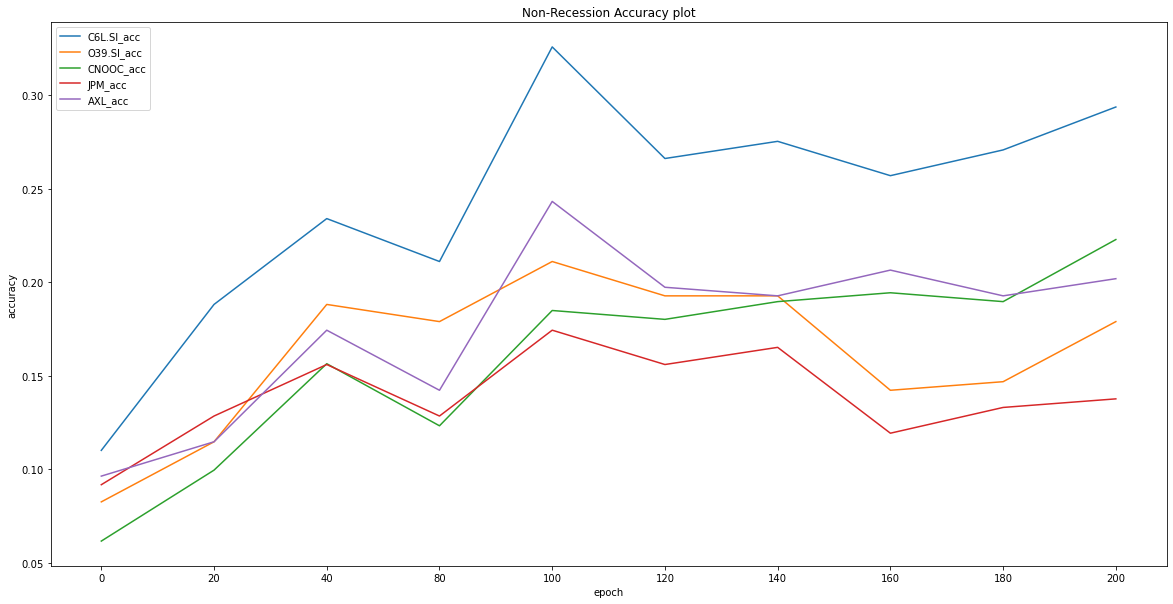

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

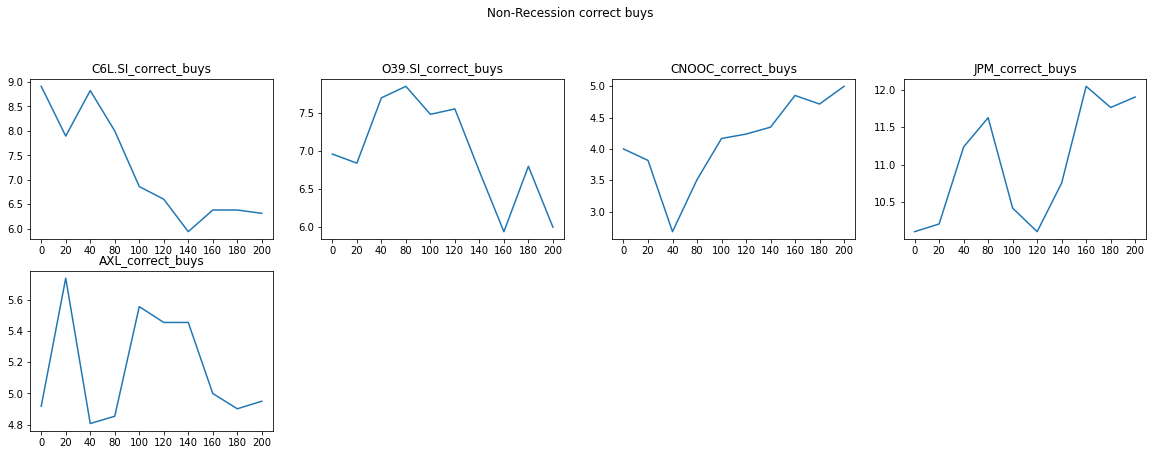

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

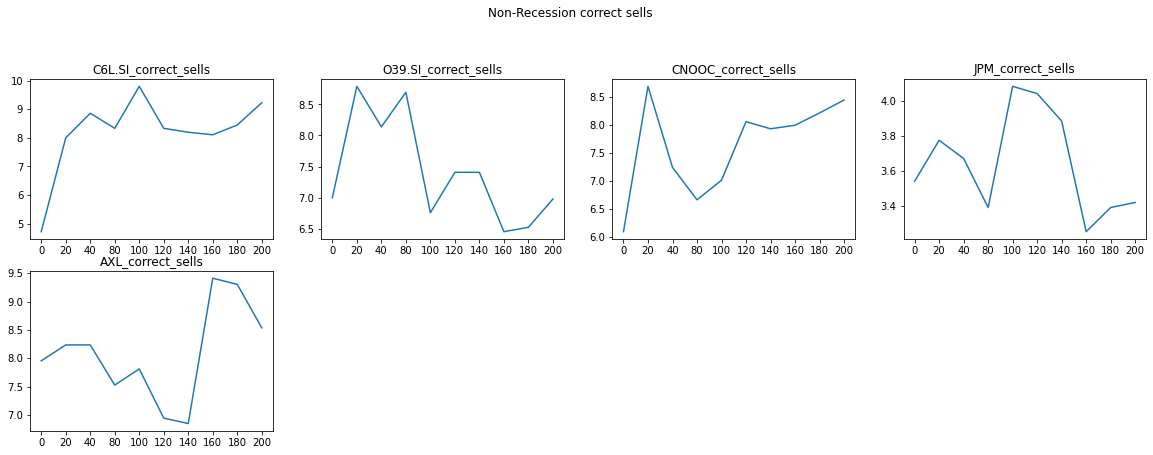

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

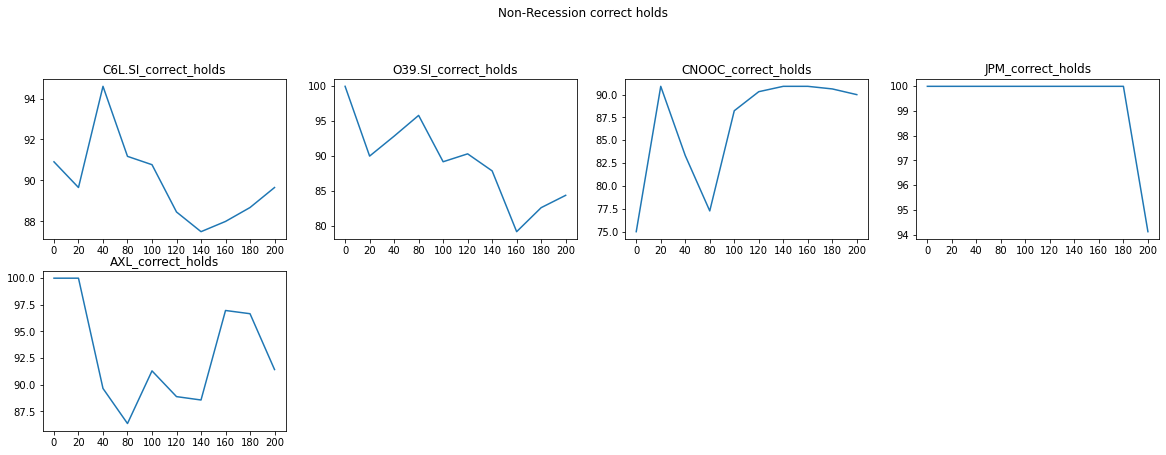

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

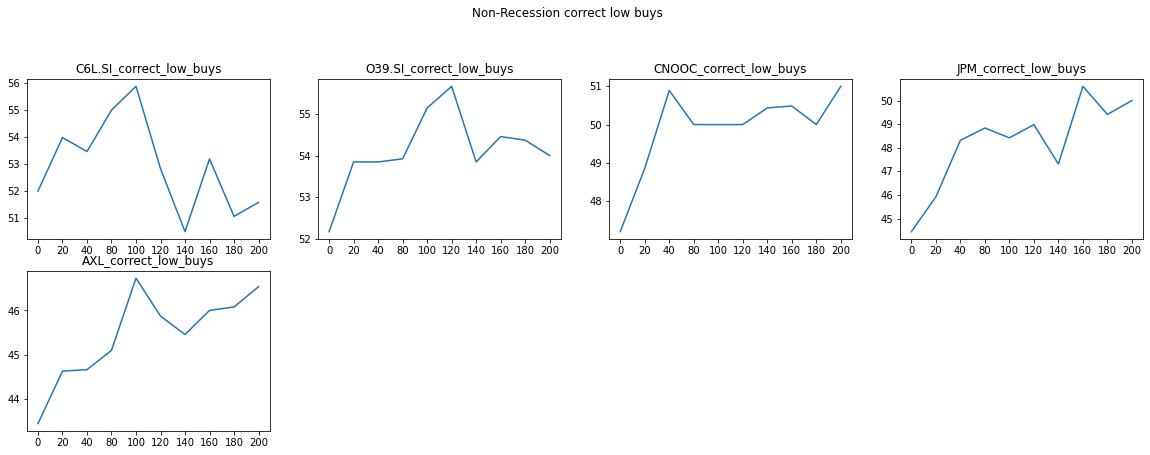

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

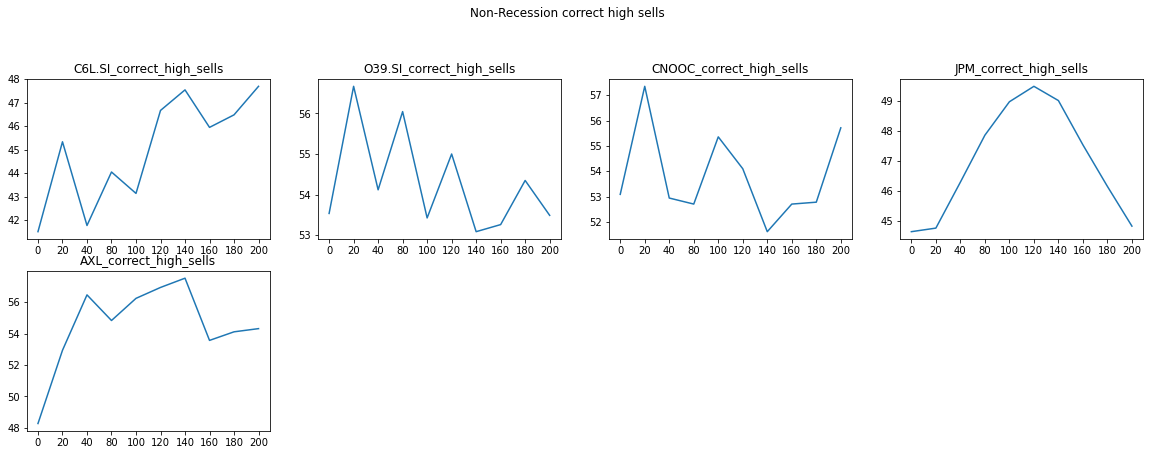

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

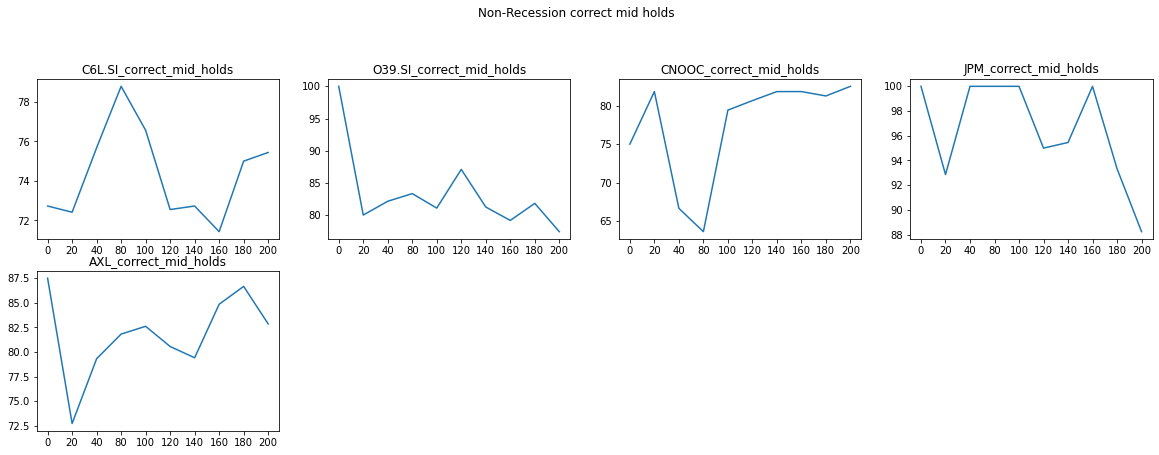

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

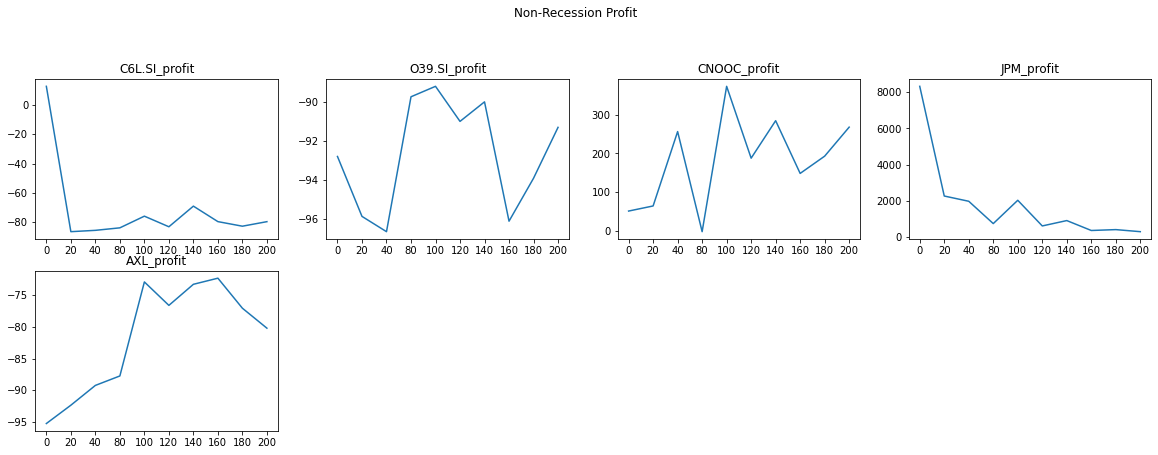

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [31]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


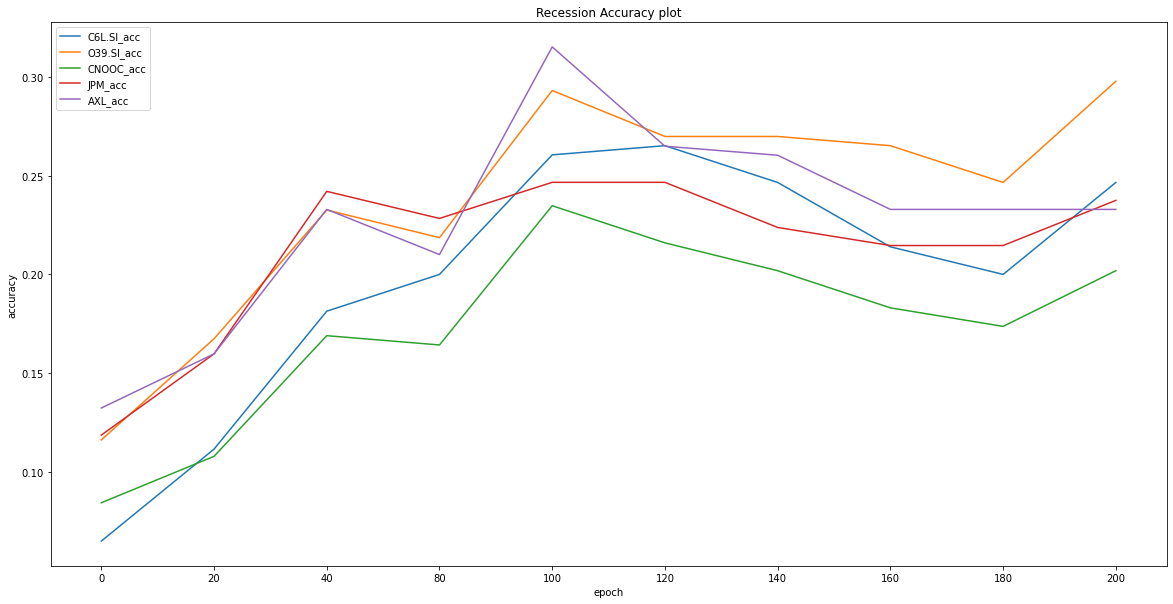

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

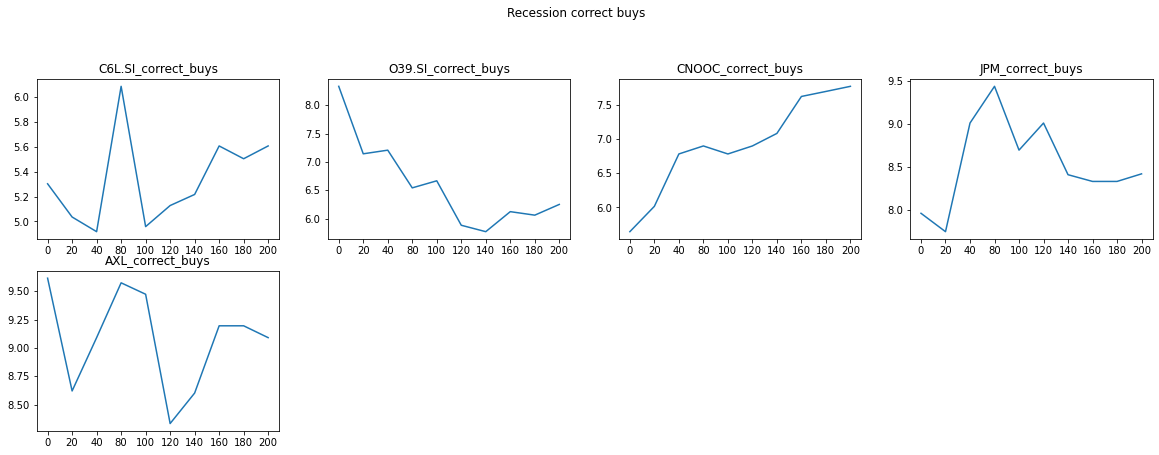

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

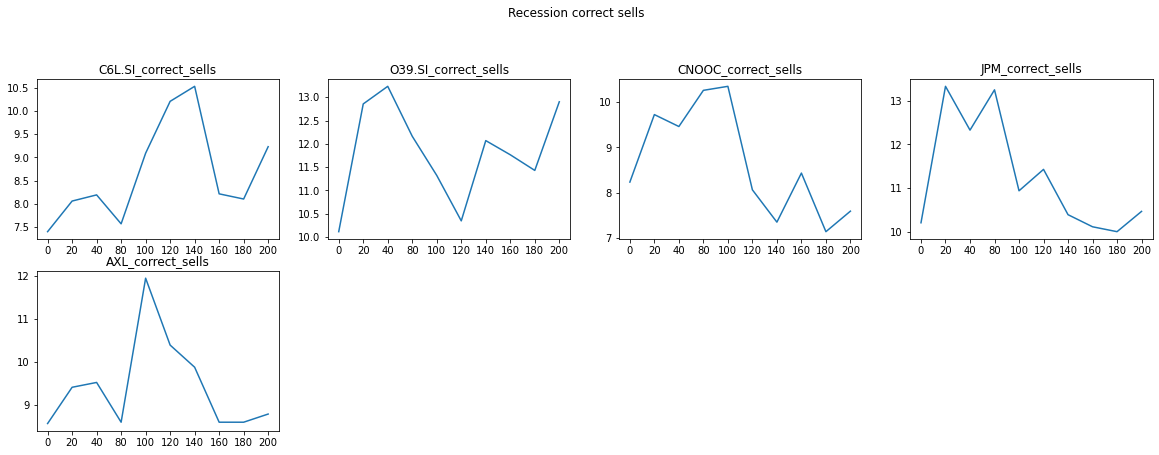

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

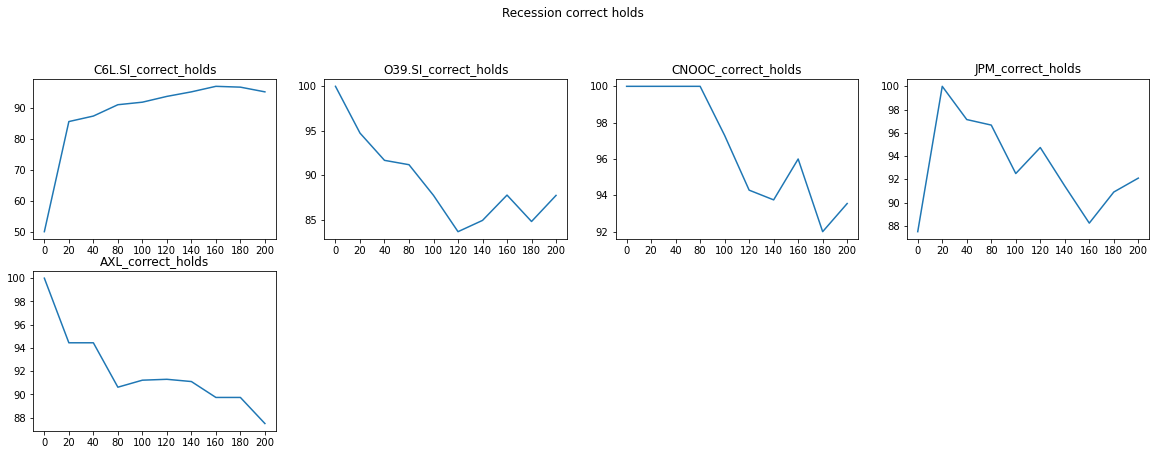

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

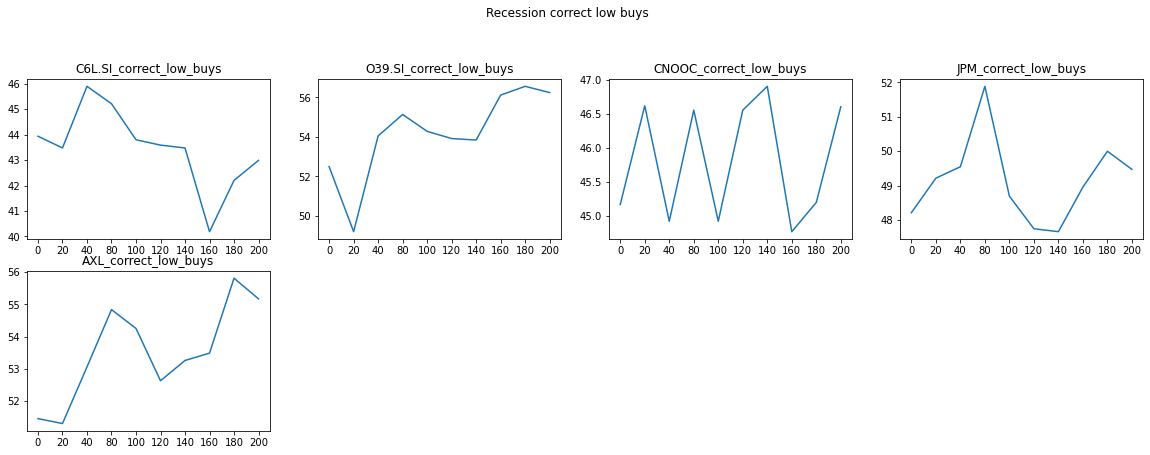

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

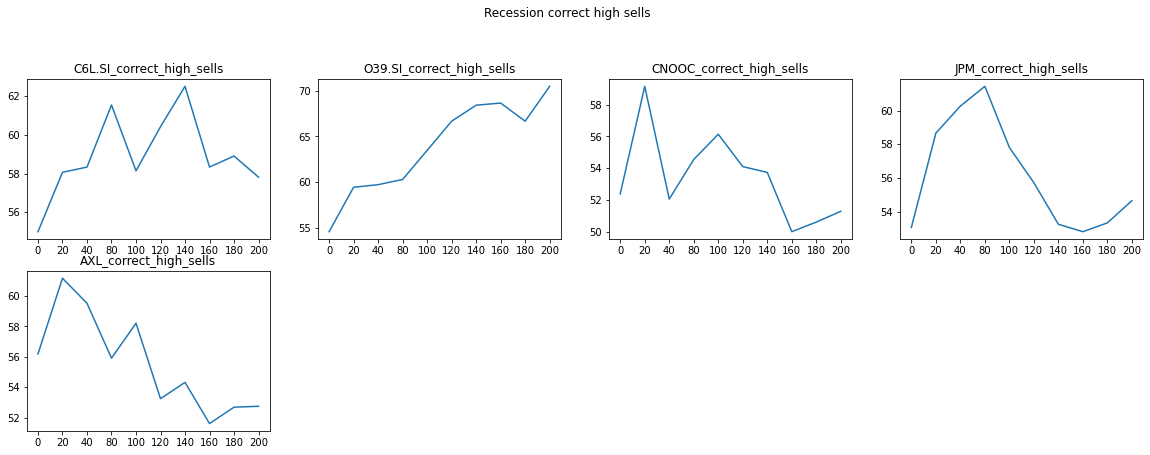

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

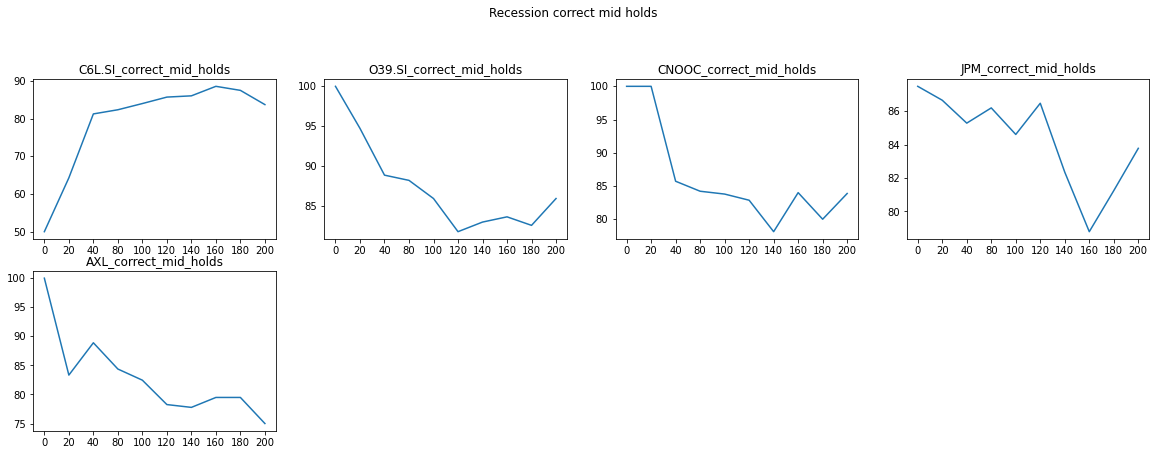

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

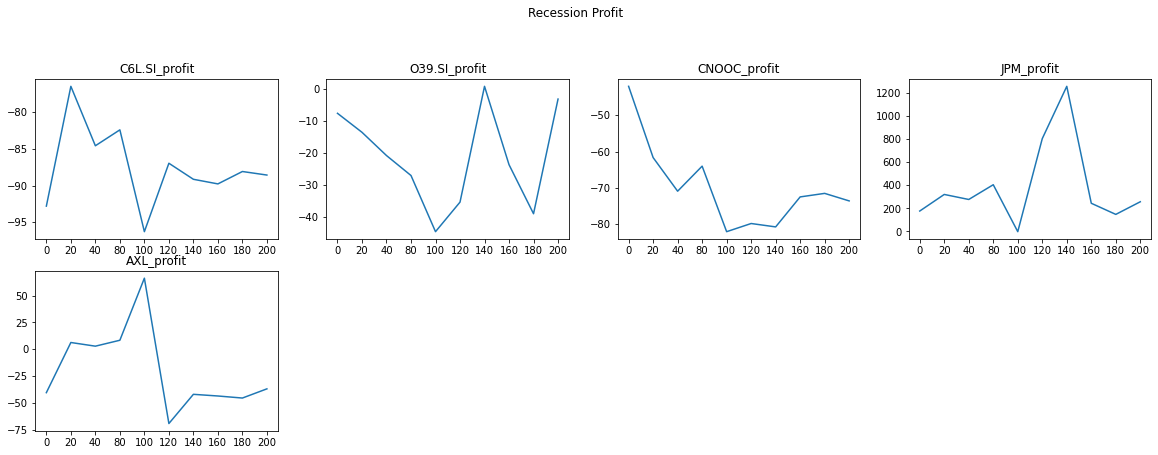

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")